# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import imageio # import the imageio module
from skimage.transform import resize
import datetime
import os

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import pathlib

# rootfolder = '/content/drive/MyDrive/Colab Notebooks/Gesture-Recognition'
# zipfilepath = pathlib.Path(rootfolder + '/Project_data.zip')

In [4]:
# print(zipfilepath)

In [5]:
# !apt install unzip

# !unzip '/content/drive/MyDrive/Colab Notebooks/Gesture-Recognition/Project_data.zip' -d '/content/drive/MyDrive/Colab Notebooks/Gesture-Recognition/'

We set the random seed so that the results don't vary drastically.

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
# train_doc = np.random.permutation(open('/content/drive/MyDrive/Colab Notebooks/Gesture-Recognition/Project_data/train.csv').readlines())
# val_doc = np.random.permutation(open('/content/drive/MyDrive/Colab Notebooks/Gesture-Recognition/Project_data/val.csv').readlines())

train_doc = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())
batch_size = 64

print("Number of lines in Train document :: "+str(len(train_doc)))
print("Number of lines in Test document :: "+str(len(train_doc)))

Number of lines in Train document :: 663
Number of lines in Test document :: 663


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
def prepare_image(image, channel, height, width):
  image = resize(image, (height, width), anti_aliasing=True)
  image = (image[...,channel])/255
  return image

In [9]:
img_idx = np.round(np.linspace(0,29,20)).astype(int)
print(img_idx)

[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]


In [10]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    height = 120
    width = 120
    num_images = 20

    img_idx = np.round(np.linspace(0,29,num_images)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,num_images,height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = prepare_image(image, 0, height, width)
                    batch_data[folder,idx,:,:,1] = prepare_image(image, 1, height, width)
                    batch_data[folder,idx,:,:,2] = prepare_image(image, 2, height, width)

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_size = len(t)%batch
            batch_data = np.zeros((batch_size,num_images,height,width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    batch_data[folder,idx,:,:,0] = prepare_image(image, 0, height, width)
                    batch_data[folder,idx,:,:,1] = prepare_image(image, 1, height, width)
                    batch_data[folder,idx,:,:,2] = prepare_image(image, 2, height, width)

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
# train_path = '/content/drive/MyDrive/Colab Notebooks/Gesture-Recognition/Project_data/train'
# val_path = '/content/drive/MyDrive/Colab Notebooks/Gesture-Recognition/Project_data/val'

train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [12]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /datasets/Project_data/train ; batch size = 64
(64, 20, 120, 120, 3)
Source path =  /datasets/Project_data/val ; batch size = 64
(64, 20, 120, 120, 3)


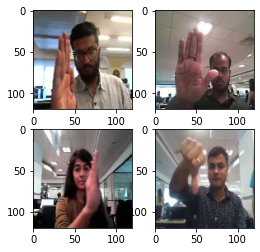

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2, figsize=(4,4))
ax[0,0].imshow(sample_batch_data[16,10,:,:,:])   
ax[0,1].imshow(sample_batch_data[25,10,:,:,:])

ax[1,0].imshow(sample_val_batch_data[16,10,:,:,:])   
ax[1,1].imshow(sample_val_batch_data[25,10,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimiser = #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)